In [1]:
import pandas as pd
import numpy as np
from sklearn import svm
from sklearn import tree
from sklearn.linear_model import LogisticRegression as lr
import graphviz
import nltk
from nltk.chunk import *
from nltk.chunk.util import *
from nltk.chunk.regexp import *
from nltk import Tree
import json
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

In [2]:
def ruleBasedSearch(sentenceList):
    # return new dataframe, colName: to be, other verb, verb, punctuation, pronoun
    newPd = pd.DataFrame(columns=['toBe','defVerb','verb','punctuation','pronoun'])
    for sen in sentenceList:
        #print(sen)
        result = [0]*5
        # tobe
        reTOBE = re.compile(r'\b(be|is|are|was|were|being|={1})\b', flags=re.IGNORECASE)
        if (reTOBE.findall(sen)!=[]):
            result[0] = 1
        # defVerb
        reDefVerb = re.compile(r'\b(as|define|defines|defined|mean|means|meant|refer|refers|referred{1})\b', flags=re.IGNORECASE)
        if (reDefVerb.findall(sen)!=[]):
            result[1] = 1
        # punctuation
        rePunc = re.compile(r'(:|-|\()')
        if (rePunc.findall(sen)!=[]):
            result[3] = 1
        
        
        tokens = nltk.word_tokenize(sen)
        tagged = nltk.pos_tag(tokens)
        #print(tagged)

        tagged_text_string = " ".join(["{}/{}".format(word,pos) for word, pos in tagged])
        gold_chunked_text = tagstr2tree(tagged_text_string)
        unchunked_text = gold_chunked_text.flatten()
        
        # verb
        chunk_rule = ChunkRule("<VB|VBG|VBD|VBN|VBP|VBZ>", "Chunk verb")
        chunk_parser = RegexpChunkParser([chunk_rule], chunk_label='NP')
        chunked_text = chunk_parser.parse(unchunked_text)
        #print(chunked_text)
        if (chunked_text.height()>=3):
            result[2] = 1
        # pronoun
        chunk_rule1 = ChunkRule("<PRP|PRP\$>", "Chunk pronoun")
        chunk_parser1 = RegexpChunkParser([chunk_rule1], chunk_label='NP')
        chunked_text1 = chunk_parser1.parse(unchunked_text)
        if (chunked_text1.height()>=3):
            result[4] = 1
        
        """
        posTag = ' '.join(pos for _,pos in nltk.pos_tag(nltk.word_tokenize(sen)))
        print(posTag)
        # verb
        reVerb = re.compile(r'(VB?)', flags=re.IGNORECASE)
        if (reVerb.findall(sen)!=[]):
            result[2] = 1
        # pronoun
        rePronoun = re.compile(r'(PRP)', flags=re.IGNORECASE)
        if (rePronoun.findall(sen)!=[]):
            result[4] = 1
        """
        newPd.loc[len(newPd)] = result
    return newPd

In [3]:
# process sentence tagged as "text", replace math expressions with different tokens
# if the math expression contains the symbol of interest, replace with TARGET
# else, replace with MATH
def token_math(sentence, symbol):

    expres = []
    splits = sentence.split("$")
    
    for idx in range(len(splits)):
        if idx % 2 == 1:
            expres.append(splits[idx])
            
            if symbol in splits[idx]:
                splits[idx] = "TARGET"
            else:
                splits[idx] = 'MATH'
    
    return ''.join(splits), expres



def equationSide(math, symbol):
#     output: 0 - no equal sign
#         1 - target symbol on right-hand side
#         2 - target symbol on left-hand side
    segment = math.split("=")
    if (len(segment)==1):
        # no = sign
        return 0
    if (symbol in segment[0]):
        # appear on lhs
        for i in range(1,len(segment)):
            # both on lhs & rhs
            if (symbol in segment[i]):
                return 0
        return 2
    for i in range(1,len(segment)):
        if (symbol in segment[i]):
            return 1
    return 0

def getEquationSide(mathSegment, symbol):
    label = []
    for math in mathSegment:
        label.append(equationSide(math, symbol))
    return max(label)
        

#test case
print(equationSide("\\lambda1324\n","lambda"))
print(equationSide("\\lada1324=lambda\n","lambda"))
print(equationSide("\\lambda=1324\n","lambda"))
print(getEquationSide(["\\lambda1324\n", "\\lalambdada1324=\n"], "lambda"))

0
1
2
2


In [4]:
def get_data(sentenceFile, paperFile):
#     input: sentenceFile: list of parsed sentence file
#             paperFile: name of all the paper sentences
    #df = pd.DataFrame(columns=["sentence", "position", "numAppearance", "label"])
    table = []
    paper = json.load(open(paperFile))

    for senFile in sentenceFile:
        # load sentence json
        sentence = json.load(open(senFile))
        docname = sentence["doc_name"]
        symbolExpr = sentence["symbol_expr"]
        sentences = sentence["sentences"]
        totalAppearance = len(sentences)
        # get total number of sentences in that paper
        totalSentenceLen = len(paper[docname])
        totalSentence = paper[docname][totalSentenceLen-1]["sentence_idx"]+1

        for i in range(len(sentences)):
            if (sentences[i]["type"]=="text"):
                precessedSen, mathSegment = token_math(sentences[i]["expr"], symbolExpr.strip())
                equLabel = getEquationSide(mathSegment, symbolExpr.strip())
            elif (sentences[i]["type"]=="math"):
                precessedSen = sentences[i]["expr"]
                equLabel = getEquationSide([precessedSen], symbolExpr)
            else:
                print("Unknown type label when parsing the file:"+sentences[i]["type"])
                continue

            temp = [precessedSen, len(sentences[i]["expr"]), sentences[i]["sentence_idx"]/totalSentence, (i+1)/totalAppearance, equLabel,0]
            if (sentences[i]["label"]=="definition"):
                temp[5] = 2
            elif (sentences[i]["label"]=="usecase"):
                temp[5] = 1
            #print(temp)
            table.append(temp)

    df = pd.DataFrame(table, columns=["sentence", "len","position", "numAppearance", "rhsOrlhs","label"])
    #print(df)

    # get sentence structure attributes
    vec = ruleBasedSearch(df[df.columns[0]].tolist())
    df = pd.concat([df,vec], axis=1)
    #print(df)
    print(df.shape)
    return df

In [5]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from sklearn import svm
from sklearn import tree
from sklearn.linear_model import LogisticRegression as lr
import graphviz
import nltk
from nltk.chunk import *
from nltk.chunk.util import *
from nltk.chunk.regexp import *
from nltk import Tree

def wordToVec(sentences):
    vec = np.zeros(len(sentences))
    word = [s.split(' ') for s in sentences]
    #print(word)
    model = Word2Vec(word, min_count=1)
    #print(model.wv.get_vector(word[0][0]).shape)
    for i in range(len(word)):
        temp = np.zeros(100)
        for j in range(len(word[i])):
            temp += model.wv.get_vector(word[i][j])
        # take average of the sentences
        vec[i] = np.sum(temp)
    #print(vec)
    return vec

# load data
# get label: definition - 2, usecase - 1, none - 0, unknown - 0
# attribute: sentence, position: num_sentence/total_sentence, 
#           numAppearance: number of symbol appearance/total number of appearance
#           rhsOrlhs: if there is a math equatino appears, whether the target symbol is on rhs(1) or lhs(2)
# sentence structure attribute: to be, other verb, verb, punctuation, pronoun

sentenceFile = ["face_detection_x_i.json","faster_rcnn_lambda.json","transfer_learning_Delta.json",
               "End_to_end_weakly_supervised_semantic_alignment_g.json","End_to_end_weakly_supervised_semantic_alignment_mathcalT_g.json",
               "Input_Convex_Neural_Networks_mathcalP.json","Input_Convex_Neural_Networks_mathcalY.json"]
paperFile = "output_new.json"

df = get_data(sentenceFile, paperFile)

# vec = wordToVec(df[df.columns[0]].tolist())
# df.insert(1,"vec",vec,allow_duplicates=True)

# generate training data and labels
X = df[['len','position', 'numAppearance','rhsOrlhs','toBe','defVerb','verb','punctuation','pronoun']]
#X = df[['vec','len','position', 'numAppearance']]
Y = df['label']


(126, 11)


In [6]:
# SVM
clf = svm.SVC(kernel='linear')
clf.fit(X,Y)
print("algo coefficients:")
print(clf.coef_)
print("intercept:")
print(clf.intercept_)

algo coefficients:
[[-0.00535613 -0.2831233   1.52189973 -0.29714876 -0.35722327 -0.60037329
   0.08698965 -0.66258206 -1.17648215]
 [-0.00411549  0.61279742  1.6926356   0.77285024 -1.10271465 -0.17022006
  -0.24820792 -0.09391556 -0.39439308]
 [ 0.0064611   0.3461542  -0.17677606  0.89670011 -0.15877085  0.27070895
  -0.99272492  0.5821202   0.4024776 ]]
intercept:
[ 1.33491924  0.78358621 -0.71693922]


In [7]:
# Multinomial Logit
mlr = lr(multi_class="multinomial", solver="newton-cg")
mlr.fit(X,Y)
print("algo coefficients:")
print(mlr.coef_)
print("intercept:")
print(mlr.intercept_)
# print("difference in coefficients:")
# print(clf.coef_-mlr.coef_)
# print("difference in intercept:")
# print(clf.intercept_-mlr.intercept_)

algo coefficients:
[[-6.92228392e-03 -2.44798671e-01  1.77363656e+00  9.29859194e-02
  -3.76227897e-01 -4.70153041e-02 -4.36631075e-01 -4.07370758e-01
  -6.38548987e-01]
 [ 5.16666365e-03  3.47476633e-01 -9.37949513e-01  5.11994281e-01
   1.28601818e-01  4.37082833e-01 -2.61109304e-01  3.93499834e-01
   4.50502147e-01]
 [ 1.75562027e-03 -1.02677962e-01 -8.35687046e-01 -6.04980200e-01
   2.47626079e-01 -3.90067529e-01  6.97740378e-01  1.38709240e-02
   1.88046839e-01]]
intercept:
[ 1.48322389 -0.80405418 -0.67916971]


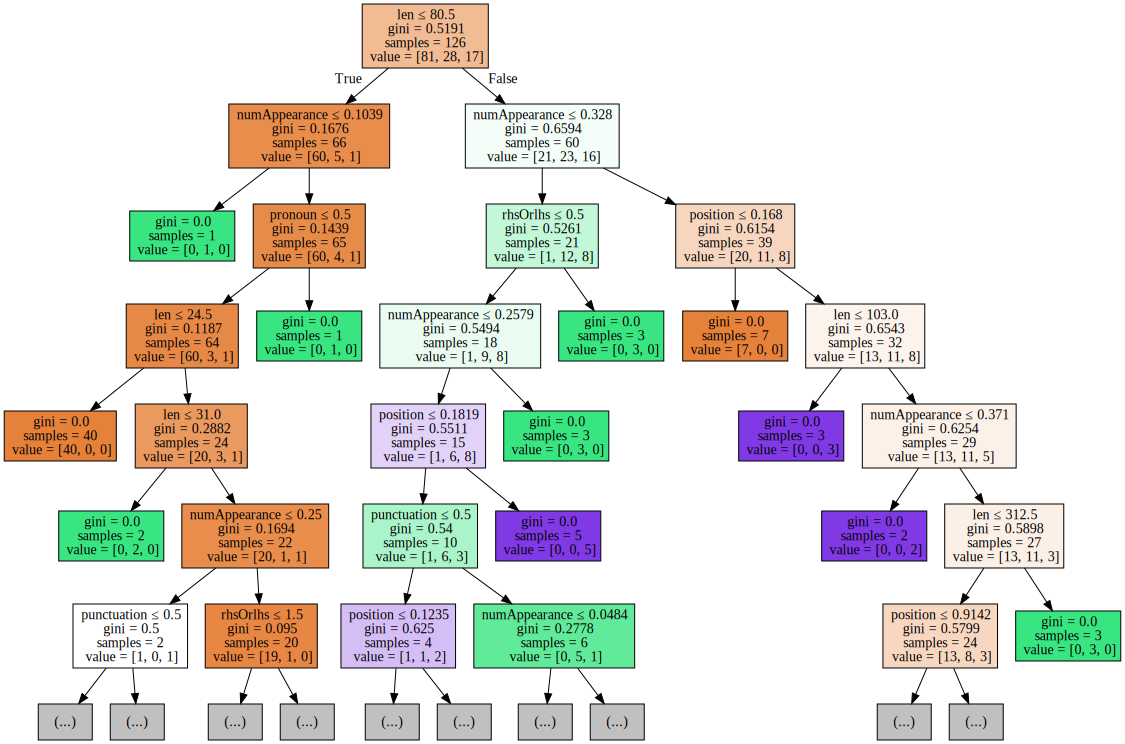

In [8]:
# decision tree
dtree = tree.DecisionTreeClassifier()
dtree.fit(X,Y)
#print(dtree.decision_path(X))
dot_data = tree.export_graphviz(dtree, out_file=None, feature_names=X.columns.values,
                                filled=True,special_characters=True, max_depth=6)
graph = graphviz.Source(dot_data)
graph

In [13]:
def get_test_stats(gt, pre, avg="macro"):
#     input: gt: ground truth (list)
#             pre: prediction of algorithm (list)
    if (len(gt)!=len(pre)):
        return None
    score = precision_recall_fscore_support(gt, pre, average=avg)
    return score[:3]

In [14]:
# test data
sentenceFile = ["WaveNet_A_Generative_Model_for_Raw_Audio_x_t.json"]
paperFile = "output_new.json"

df_test = get_data(sentenceFile, paperFile)


# vec = wordToVec(df_test[df_test.columns[0]].tolist())
# df_test.insert(1,"vec",vec,allow_duplicates=True)
# X_test = df_test[['vec','len','position', 'numAppearance']]
X_test = df_test[['len','position', 'numAppearance','rhsOrlhs','toBe','defVerb','verb','punctuation','pronoun']]
Y_test = df_test['label']

# our label
print("our label:")
print(Y_test.tolist())

# SVM
print("SVM prediction result:")
print(clf.predict(X_test))
print(get_test_stats(Y_test.tolist(), clf.predict(X_test)))

# Multinomial Logit
print("Multinomial Logit prediction result:")
print(mlr.predict(X_test))
print(get_test_stats(Y_test.tolist(), mlr.predict(X_test)))

# decision tree
print("RF prediction result:")
print(dtree.predict(X_test))
print(get_test_stats(Y_test.tolist(), dtree.predict(X_test)))


print(df_test[['sentence','label']])

(18, 11)
our label:
[1, 1, 1, 0, 1, 0, 2, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]
SVM prediction result:
[0 1 2 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0]
(0.532051282051282, 0.5, 0.5055555555555555)
Multinomial Logit prediction result:
[0 1 0 0 2 0 1 0 1 0 0 0 0 0 0 0 0 0]
(0.48412698412698413, 0.4444444444444444, 0.44148148148148153)
RF prediction result:
[1 1 2 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
(0.5952380952380952, 0.5, 0.5155555555555555)
                                             sentence  label
0                                              TARGET      1
1   $$p\left(\mathbf{x}\right)=\prod_{t=1}^{T}p\le...      1
2   Each audio sample  TARGET  is therefore condit...      1
3                                           $$x_{t}$$      0
4    The model outputs a categorical distribution ...      1
5                                           $$x_{t}$$      0
6    By using causal convolutions, we make sure th...      2
7       $$p\left(x_{t+1}\mid x_{1},...,x_{t}\right)$$      0
8   One approach to modeli

In [9]:
#sen = "This demonstrates that the result is insensitive to EQUATION in a wide range"
#sen = "$$\\displaystyle+\\lambda\\frac{1}{N_{\\mathit{reg}}}\\sum_{i}p^{*}_{i}L_{\\mathit{reg%\n}}(t_{i},t^{*}_{i}).$$"
sen = "By default we set  $\\lambda = 10$ , and thus both  cls  and  reg  terms are roughly equally weighted"
tokens = nltk.word_tokenize(sen)
tagged = nltk.pos_tag(tokens)
print(tagged)

[('By', 'IN'), ('default', 'NN'), ('we', 'PRP'), ('set', 'VBP'), ('$', '$'), ('\\lambda', 'JJ'), ('=', 'NNP'), ('10', 'CD'), ('$', '$'), (',', ','), ('and', 'CC'), ('thus', 'RB'), ('both', 'DT'), ('cls', 'NN'), ('and', 'CC'), ('reg', 'NN'), ('terms', 'NNS'), ('are', 'VBP'), ('roughly', 'RB'), ('equally', 'RB'), ('weighted', 'JJ')]


163
